# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime as dt
from datetime import timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score
import os
import cx_Oracle
import time
from scipy.stats import binom
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\GSPN - Summary")

# Read Data

In [2]:
# conn = cx_Oracle.connect('HCIN_Jainr1[AP_UWI]','Saber@1989!1','INCL02.IN.PROD/HWIN_USR_DEV.HOMECREDIT.IN')
# query = """
# SELECT
# skp_credit_case,
# TIME_CREATION_DATE, 
# c.skp_salesroom,
# POS_GSPN_V2, 
# POS_TYPE,
# client_exi_3m,
# RISK_FSTQPD30,
# RISK_AGRF120, 
# RISK_FSTPD30,
# RISK_AGRF90,
# RISK_FSPD30,
# RISK_AGRF60, 
# RISK_FPD30,
# RISK_AGRF30,
# RISK_FPD10,
# RISK_AGRF10,
# TIME_DUE_DATE,
# RISK_SPD30,
# RISK_TPD30,
# RISK_4PD30,
# FLAG_1PCT_PHANTOM, RISK_FSTQPD60,RISK_AGRF180
# FROM
# AP_UWI.UW_DAILY_DATA_ALL c
# where time_Creation_date>= DATE'2018-07-01'
# and product_group = 'CD'
# and decision_overall = 'Approved'
# order by skp_credit_case asc
# ;
# """

# data = pd.read_sql(query, conn)
# data.to_csv(os.getcwd()+"\Data Files\combined.csv", index = False)

In [3]:
df= pd.read_csv(os.getcwd()+"\Data Files\combined.csv")

In [4]:
df.to_csv(os.getcwd()+"\Data Files\combined.csv", index = False)

# Define Key Variables

In [5]:
TIME_CREATION_DATE = 'TIME_CREATION_DATE'
OLD_GSPN_SCORE = 'POS_GSPN_V2'
TARGET = 'RISK_FSTQPD60'
PHANTOMAS_FLAG = 'FLAG_1PCT_PHANTOM'
AGRF_FLAG = "RISK_AGRF120"

# Format Date Columns

In [6]:
df.TIME_CREATION_DATE = pd.to_datetime(df[TIME_CREATION_DATE], format = '%Y-%m-%d')
df["MONTH"] = df[TIME_CREATION_DATE].dt.strftime("%Y-%m")

In [7]:
df.head()

,SKP_CREDIT_CASE,TIME_CREATION_DATE,SKP_SALESROOM,POS_GSPN_V2,POS_TYPE,CLIENT_EXI_3M,RISK_FSTQPD30,RISK_AGRF120,RISK_FSTPD30,RISK_AGRF90,...,TIME_DUE_DATE,RISK_SPD30,RISK_TPD30,RISK_4PD30,Unnamed: 0.1,PHANTOM_FLAG,FLAG_1PCT_PHANTOM,RISK_FSTQPD60,RISK_AGRF180,MONTH
0,198274875,2018-07-01,119504,NaN,AP,N,0.0,1.0,0.0,1.0,...,01-08-18,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-07
1,198274876,2018-07-01,1845809,NaN,AP,N,0.0,0.0,0.0,0.0,...,01-01-00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-07
2,198274878,2018-07-01,1285577,NaN,Aldi,N,0.0,1.0,0.0,1.0,...,01-08-18,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-07
3,198274968,2018-07-01,11007354,NaN,Aldi,N,0.0,1.0,0.0,1.0,...,01-08-18,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-07
4,198274969,2018-07-01,1080164,NaN,AP,N,0.0,1.0,0.0,1.0,...,01-08-18,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-07


# Create Features

In [8]:
features = pd.DataFrame({'features' : ["RISK_AGRF10","RISK_FPD10","RISK_AGRF30","RISK_FPD30","RISK_AGRF60","RISK_FSPD30","RISK_AGRF90","RISK_FSTPD30","RISK_AGRF120","RISK_FSTQPD30"],
                         'start' : [0,0,0,0,121,121,151,151,211,211],
                         'end' : [90,90,120,120,150,150,210,210,270,270]
})

df_model = pd.DataFrame()

for MON in ('2019-05','2019-06','2019-07','2019-08','2020-06','2020-07','2020-08','2020-09','2020-10'):

    MON = pd.datetime(int(MON[0:4]),int(MON[-2:]),1)
    df_obs = df[(df.TIME_CREATION_DATE>= MON) & (df.TIME_CREATION_DATE < MON + timedelta(30))]

    df_features=pd.DataFrame(df[(df.TIME_CREATION_DATE<MON)&(df.TIME_CREATION_DATE>MON-timedelta(180))].groupby("SKP_SALESROOM")["SKP_CREDIT_CASE"].count())
    df_features.rename(columns={"SKP_CREDIT_CASE":"CASE_COUNT"}, inplace = True)

    for x in range(features.shape[0]):
        df_features[features.loc[x,'features']+"_SUM"] = df[(df.TIME_CREATION_DATE<=MON-timedelta(int(features.loc[x,'start'])))&(df.TIME_CREATION_DATE>=MON-timedelta(int(features.loc[x,'end'])))].groupby('SKP_SALESROOM')[features.loc[x,'features']].sum()
        
    df_features["RISK_FPD10_RATE"] = df_features.RISK_FPD10_SUM/df_features.RISK_AGRF10_SUM
    df_features["RISK_FPD30_RATE"] = df_features.RISK_FPD30_SUM/df_features.RISK_AGRF30_SUM
    df_features["RISK_FSPD30_RATE"] = df_features.RISK_FSPD30_SUM/df_features.RISK_AGRF60_SUM
    df_features["RISK_FSTPD30_RATE"] = df_features.RISK_FSTPD30_SUM/df_features.RISK_AGRF90_SUM
    df_features["RISK_FSTQPD30_RATE"] = df_features.RISK_FSTQPD30_SUM/df_features.RISK_AGRF120_SUM

    #NA Treatment 
    var_list = ["RISK_FPD10_RATE","RISK_FPD30_RATE","RISK_FSPD30_RATE","RISK_FSTPD30_RATE","RISK_FSTQPD30_RATE"]
    df_features[var_list]= df_features[var_list].fillna(df_features[var_list].mean())

    df_features.reset_index(inplace = True)
    df_obs= df_obs.merge(df_features,how = 'inner', on=['SKP_SALESROOM'])
    df_model = pd.concat([df_model,df_obs])

df_model.dropna(subset = [TARGET], inplace = True)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # Remove the CWD from sys.path while we load stuff.


### 1 Hot Encoding POS Type

In [9]:
for x in ["POS_TYPE"]:
    dummy = pd.get_dummies(df_model[x])
    dummy.columns = [y+"_"+x for y in dummy.columns]
    df_model = pd.concat([df_model, dummy], axis=1)

### Add Geo Score

In [10]:
# conn = cx_Oracle.connect('HCIN_Jainr1[AP_UWI]','Saber@1989!1','INCL02.IN.PROD/HWIN_USR_DEV.HOMECREDIT.IN')
# query = """
# select skp_salesr as skp_salesroom, a.grid_id, month, combined_score_knn_exi, combined_score_knn_ntc
# from AP_BI.T_SDE_POS_23JAN2020 a 
# join bd_grid_score_hist b
# on a.grid_id = b.grid_id;
# """

# data = pd.read_sql(query, conn)
# data.to_csv(os.getcwd()+"\Data Files\grid_scores.csv")

In [11]:
df_grid = pd.read_csv(os.getcwd()+"\Data Files\grid_scores.csv")
df_grid.MONTH = pd.to_datetime(df_grid.MONTH, format = '%d-%m-%y')
df_grid["MONTH"] = df_grid.MONTH.dt.strftime("%Y-%m")

df_model = df_model.merge(df_grid, how='left', on = ["SKP_SALESROOM","MONTH"])

df_model[["COMBINED_SCORE_KNN_EXI","COMBINED_SCORE_KNN_NTC"]]=df_model[["COMBINED_SCORE_KNN_EXI","COMBINED_SCORE_KNN_NTC"]].fillna(
df_model[["COMBINED_SCORE_KNN_EXI","COMBINED_SCORE_KNN_NTC"]].mean())

# Read Model

In [16]:
bst = pickle.load(open("gspn_model","rb"))

In [17]:
x_columns = ["CASE_COUNT","RISK_FPD30_RATE","RISK_FSPD30_RATE","RISK_FSTPD30_RATE","RISK_FSTQPD30_RATE", "COMBINED_SCORE_KNN_EXI",
            "COMBINED_SCORE_KNN_NTC","AP_POS_TYPE","Aldi_POS_TYPE","Satellite_POS_TYPE","UDAAN_POS_TYPE"]

In [18]:
df_model["GSPN_SCORE"] =  bst.predict_proba(df_model[x_columns])[:, 1]

### Model Equation

In [19]:
pd.DataFrame({"column":x_columns,"coeffecient":bst.coef_[0]})

,column,coeffecient
0,CASE_COUNT,-0.000104
1,RISK_FPD30_RATE,4.092211
2,RISK_FSPD30_RATE,0.499803
3,RISK_FSTPD30_RATE,1.053096
4,RISK_FSTQPD30_RATE,1.220143
5,COMBINED_SCORE_KNN_EXI,9.802135
6,COMBINED_SCORE_KNN_NTC,0.461811
7,AP_POS_TYPE,-1.632877
8,Aldi_POS_TYPE,-1.502378
9,Satellite_POS_TYPE,-1.501776


# Model Evaluation

### Define GSPN Clusters (Keeping Proportion Same as Current Setup)

In [20]:
df_model["GSPN_GROUP"]=np.where(df_model["GSPN_SCORE"]<0.079452, 1,np.where(df_model["GSPN_SCORE"]<0.115615,2,3))

## MOM Gini Trends

# FPD30

### MOM Gini (Aproved Base) : FPD30

In [35]:
df_temp = df_model.dropna(subset = [OLD_GSPN_SCORE])

gini_dic = {}
target_variable = "RISK_FPD30"
agrf_variable = "RISK_AGRF30"

df_temp = df_temp[df_temp[agrf_variable]==1]

for x in df_temp["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "OLD_GSPN" not in gini_dic: 
            gini_dic["OLD_GSPN"] = []
        if "NEW_GSPN" not in gini_dic: 
            gini_dic["NEW_GSPN"] = []
        
        gini_dic["OLD_GSPN"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x][OLD_GSPN_SCORE])-1)*100)
        gini_dic["NEW_GSPN"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GSPN_GROUP"])-1)*100)
        gini_dic["MONTH"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)

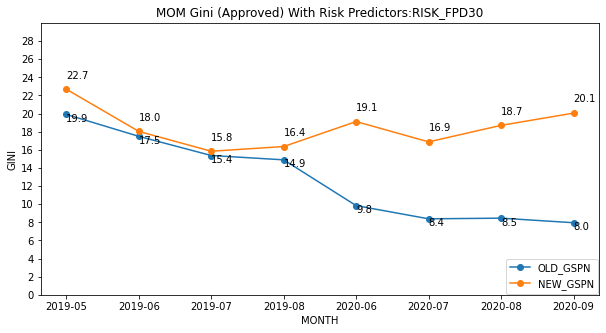

In [36]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["OLD_GSPN"], marker='o', scaley = False, label = "OLD_GSPN")
ax1.plot(gini_df["MONTH"],gini_df["NEW_GSPN"], marker='o', scaley = False, label = "NEW_GSPN")

for i, txt in enumerate(gini_df["OLD_GSPN"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["OLD_GSPN"][i]-0.8))
for i, txt in enumerate(gini_df["NEW_GSPN"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["NEW_GSPN"][i]+1.2))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,30)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,30,2))
ax1.set_title("MOM Gini (Approved) With Risk Predictors:"+target_variable)
plt.show()

### MOM Gini (Phantomas Base): FPD30

In [37]:
df_temp = df_model.dropna(subset = [OLD_GSPN_SCORE])
df_temp = df_temp[df_temp[PHANTOMAS_FLAG]==1.0]
gini_dic = {}
target_variable = "RISK_FPD30"
agrf_variable = "RISK_AGRF30"
df_temp = df_temp[df_temp[agrf_variable]==1]

for x in df_temp["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "OLD_GSPN" not in gini_dic: 
            gini_dic["OLD_GSPN"] = []
        if "NEW_GSPN" not in gini_dic: 
            gini_dic["NEW_GSPN"] = []
        
        gini_dic["OLD_GSPN"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x][OLD_GSPN_SCORE])-1)*100)
        gini_dic["NEW_GSPN"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GSPN_GROUP"])-1)*100)
        gini_dic["MONTH"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)

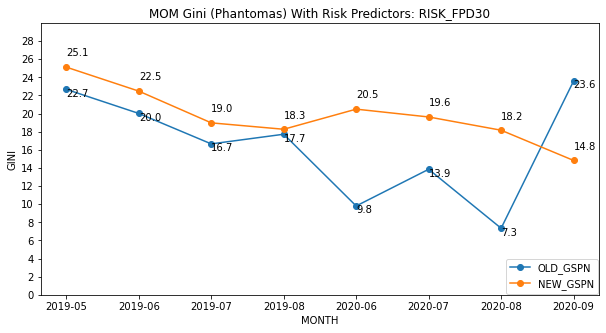

In [38]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["OLD_GSPN"], marker='o', scaley = False, label = "OLD_GSPN")
ax1.plot(gini_df["MONTH"],gini_df["NEW_GSPN"], marker='o', scaley = False, label = "NEW_GSPN")
# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["OLD_GSPN"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["OLD_GSPN"][i]-0.8))
for i, txt in enumerate(gini_df["NEW_GSPN"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["NEW_GSPN"][i]+1.2))
    
# for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,30)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,30,2))
ax1.set_title("MOM Gini (Phantomas) With Risk Predictors: "+target_variable)
plt.show()

# FSPD30

### MOM Gini (Aproved Base) : FSPD30

In [39]:
df_temp = df_model.dropna(subset = [OLD_GSPN_SCORE])

gini_dic = {}
target_variable = "RISK_FSPD30"
agrf_variable = "RISK_AGRF60"

df_temp = df_temp[df_temp[agrf_variable]==1]

for x in df_temp["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "OLD_GSPN" not in gini_dic: 
            gini_dic["OLD_GSPN"] = []
        if "NEW_GSPN" not in gini_dic: 
            gini_dic["NEW_GSPN"] = []
        
        gini_dic["OLD_GSPN"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x][OLD_GSPN_SCORE])-1)*100)
        gini_dic["NEW_GSPN"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GSPN_GROUP"])-1)*100)
        gini_dic["MONTH"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)

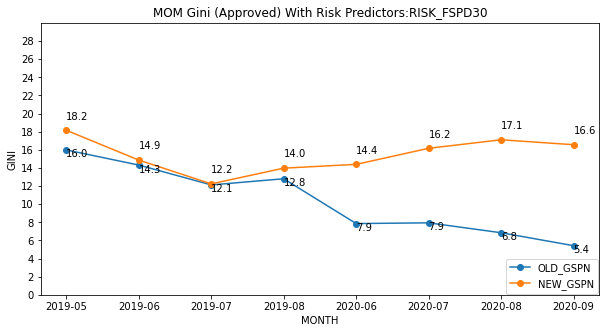

In [40]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["OLD_GSPN"], marker='o', scaley = False, label = "OLD_GSPN")
ax1.plot(gini_df["MONTH"],gini_df["NEW_GSPN"], marker='o', scaley = False, label = "NEW_GSPN")

for i, txt in enumerate(gini_df["OLD_GSPN"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["OLD_GSPN"][i]-0.8))
for i, txt in enumerate(gini_df["NEW_GSPN"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["NEW_GSPN"][i]+1.2))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,30)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,30,2))
ax1.set_title("MOM Gini (Approved) With Risk Predictors:"+target_variable)
plt.show()

### MOM Gini (Phantomas Base): FSPD30

In [41]:
df_temp = df_model.dropna(subset = [OLD_GSPN_SCORE])
df_temp = df_temp[df_temp[PHANTOMAS_FLAG]==1.0]
gini_dic = {}
target_variable = "RISK_FSPD30"
agrf_variable = "RISK_AGRF60"
df_temp = df_temp[df_temp[agrf_variable]==1]

for x in df_temp["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "OLD_GSPN" not in gini_dic: 
            gini_dic["OLD_GSPN"] = []
        if "NEW_GSPN" not in gini_dic: 
            gini_dic["NEW_GSPN"] = []
        
        gini_dic["OLD_GSPN"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x][OLD_GSPN_SCORE])-1)*100)
        gini_dic["NEW_GSPN"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GSPN_GROUP"])-1)*100)
        gini_dic["MONTH"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)

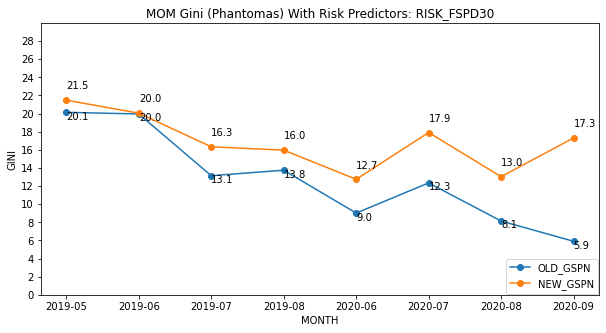

In [42]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["OLD_GSPN"], marker='o', scaley = False, label = "OLD_GSPN")
ax1.plot(gini_df["MONTH"],gini_df["NEW_GSPN"], marker='o', scaley = False, label = "NEW_GSPN")
# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["OLD_GSPN"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["OLD_GSPN"][i]-0.8))
for i, txt in enumerate(gini_df["NEW_GSPN"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["NEW_GSPN"][i]+1.2))
    
# for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,30)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,30,2))
ax1.set_title("MOM Gini (Phantomas) With Risk Predictors: "+target_variable)
plt.show()

# FSTPD30

### MOM Gini (Aproved Base) : FSTPD30

In [43]:
df_temp = df_model.dropna(subset = [OLD_GSPN_SCORE])

gini_dic = {}
target_variable = "RISK_FSTPD30"
agrf_variable = "RISK_AGRF90"

df_temp = df_temp[df_temp[agrf_variable]==1]

for x in df_temp["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "OLD_GSPN" not in gini_dic: 
            gini_dic["OLD_GSPN"] = []
        if "NEW_GSPN" not in gini_dic: 
            gini_dic["NEW_GSPN"] = []
        
        gini_dic["OLD_GSPN"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x][OLD_GSPN_SCORE])-1)*100)
        gini_dic["NEW_GSPN"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GSPN_GROUP"])-1)*100)
        gini_dic["MONTH"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)

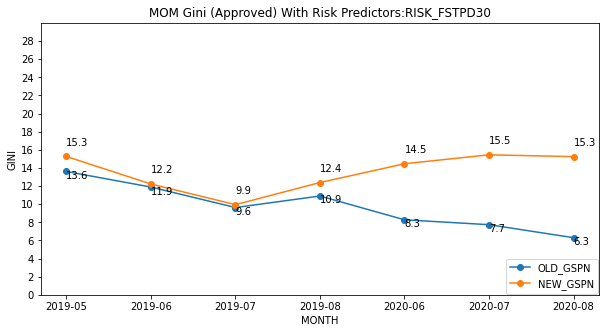

In [44]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["OLD_GSPN"], marker='o', scaley = False, label = "OLD_GSPN")
ax1.plot(gini_df["MONTH"],gini_df["NEW_GSPN"], marker='o', scaley = False, label = "NEW_GSPN")

for i, txt in enumerate(gini_df["OLD_GSPN"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["OLD_GSPN"][i]-0.8))
for i, txt in enumerate(gini_df["NEW_GSPN"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["NEW_GSPN"][i]+1.2))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,30)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,30,2))
ax1.set_title("MOM Gini (Approved) With Risk Predictors:"+target_variable)
plt.show()

### MOM Gini (Phantomas Base): FSTPD30

In [45]:
df_temp = df_model.dropna(subset = [OLD_GSPN_SCORE])
df_temp = df_temp[df_temp[PHANTOMAS_FLAG]==1.0]
gini_dic = {}
target_variable = "RISK_FSTPD30"
agrf_variable = "RISK_AGRF90"
df_temp = df_temp[df_temp[agrf_variable]==1]

for x in df_temp["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "OLD_GSPN" not in gini_dic: 
            gini_dic["OLD_GSPN"] = []
        if "NEW_GSPN" not in gini_dic: 
            gini_dic["NEW_GSPN"] = []
        
        gini_dic["OLD_GSPN"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x][OLD_GSPN_SCORE])-1)*100)
        gini_dic["NEW_GSPN"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GSPN_GROUP"])-1)*100)
        gini_dic["MONTH"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)

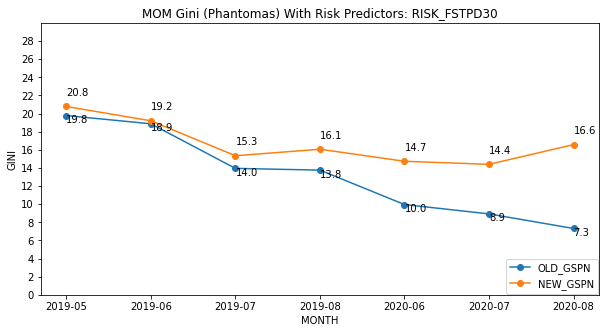

In [46]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["OLD_GSPN"], marker='o', scaley = False, label = "OLD_GSPN")
ax1.plot(gini_df["MONTH"],gini_df["NEW_GSPN"], marker='o', scaley = False, label = "NEW_GSPN")
# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["OLD_GSPN"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["OLD_GSPN"][i]-0.8))
for i, txt in enumerate(gini_df["NEW_GSPN"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["NEW_GSPN"][i]+1.2))
    
# for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,30)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,30,2))
ax1.set_title("MOM Gini (Phantomas) With Risk Predictors: "+target_variable)
plt.show()